# Task 2.1

“Given a video of the modal mask of an object, predict the amodal mask of the same object”

Inputs:
- RGB Frames - N 3-channel images (N, 3, 256, 256)
- N Modal Masks of Object i - N Binary (1-channel) images (N, 1, 256, 256)

Outputs:
- N Amodal Masks of Object i - N Binary (1-channel) images (1, 256, 256)

In [1]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [2]:
torch.cuda.is_available()

False

### Model

In [3]:

def calculate_metrics(amodal_mask_preds, 
                      amodal_mask_labels, 
                      amodal_content_preds,
                      amodal_content_labels):
    """
    Here, you can calculate non-loss metrics like mIOU, accuracy, J&F scores.

    And non-loss image generation metrics between the predicted and ground-truth amodal content
    Such as Inception Score, Frechet Inception Distance, Learned Perceptual Patch Similarity (LPIPS),
    Structure Similarity Index Metric (SSIM), Peak Signal-Noise Ratio (PSNR)

    These should all have easy-to-use implementations in libraries such as TorchMetrics.
    """
    return None


#### Class - Unet_Image

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Image(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()
        # downsampling
        # MaxPooling - keep max value over a 2x2 sliding window
        self.mpool_2 = nn.MaxPool2d((2, 2))
        
        # down path - encoding - increase dimensions
        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2) # 32 x 32
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2) # 64 x64 
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2) # 128 x128
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2) # outputs 256 x256
        
        # upsample by factor of 2, in both dimensions
        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)
        
        # up path - decoder
        # slowly reduce dimensions
        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        # no activation
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()


        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    
    # Packages the encoder path (downpath)
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        # Returns the four
        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    # packages the decode path (up-path)
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content
    
    # Encode - decode together
    # Runs through the whole model
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w) - batch size, channels, height, width
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
        
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        # This is what we use for loss calculations
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Model input
        #print('model input:', model_input.shape)
        
        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        # Compares raw logits for binary prediction - object vs no object
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels) # Binary Cross Entropy Loss
        # Pixel by pixel difference in the RGB
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels) # L1 loss
        return mask_loss, content_loss

#### Example Usage

Test model usage

In [5]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image(4)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
batch_size = 1
rand_input = torch.randn((batch_size, 4, 256, 256))

# Apply the model to the input - we use encode decode here rather than forward
# because we don't have the full batch yet - we will later
logits_amodal_mask, logits_amodal_content = model.encode_decode(rand_input)
print('Model output:', logits_amodal_mask.shape, logits_amodal_content.shape)

# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

Model output: torch.Size([1, 1, 256, 256]) torch.Size([1, 3, 256, 256])


#### Class - Unet_Image + LSTM

In [ ]:
class Unet_Image_LSTM(Unet_Image):
    def __init__(self, in_channels=4, mask_content_preds=False, input_size=(128, 128)):
        super().__init__(in_channels, mask_content_preds)
        # Dynamically infer bottleneck shape
        dummy = torch.zeros(1, in_channels, *input_size)
        with torch.no_grad():
            _, _, _, x4 = self.encode(dummy)
        _, bottleneck_channels, h_b, w_b = x4.shape
        self.bottleneck_channels = bottleneck_channels
        self.bottleneck_h = h_b
        self.bottleneck_w = w_b
        self.lstm_input_size = bottleneck_channels * h_b * w_b
        self.lstm_hidden_size = self.lstm_input_size
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

    def encode_frames(self, x, n):
        x1_list, x2_list, x3_list, x4_list = [], [], [], []
        for t in range(n): # n gives how many frames to expect
            frame_t = x[:, :, t, :, :]  # (bs, c+1, h, w), same shape as the inputs of Unet_Image
            x1, x2, x3, x4 = self.encode(frame_t)
            x1_list.append(x1)
            x2_list.append(x2)
            x3_list.append(x3)
            x4_list.append(x4)
        # Stack along time: (bs, cX, n_frames, hX, wX)
        x1_seq = torch.stack(x1_list, dim=2)
        x2_seq = torch.stack(x2_list, dim=2)
        x3_seq = torch.stack(x3_list, dim=2)
        x4_seq = torch.stack(x4_list, dim=2)
        return x1_seq, x2_seq, x3_seq, x4_seq
    
    def run_lstm(self, h4_seq):
        # Uses the last layer of encoder output
        # Prepare LSTM input: flatten spatial dims
        bs, ch, n, h_b, w_b = h4_seq.shape
        h4_seq_flat = h4_seq.permute(0, 2, 1, 3, 4).contiguous().view(bs, n, -1)  # (bs, n, ch*h_b*w_b)
        # Pass through LSTM
        lstm_out, _ = self.lstm(h4_seq_flat)  # (bs, n, hidden_size)
        # Reshape LSTM output back to spatial, then permute back to (bs, ch, n, h, w)
        lstm_out_spatial = lstm_out.view(bs, n, ch, h_b, w_b).permute(0, 2, 1, 3, 4)
        return lstm_out_spatial
    
    def decode_frames(self, h1_seq, h2_seq, h3_seq, h4_seq, n):
        # Decode each timestep
        logits_mask_seq = []
        logits_content_seq = []
        for t in range(n): # n is the number of consecutive frames
            # Picks a single entry of the time dimension resulting in (bs, c, h, w) shape
            logits_mask, logits_content = self.decode(
                h1_seq[:, :, t, :, :],
                h2_seq[:, :, t, :, :],
                h3_seq[:, :, t, :, :],
                h4_seq[:, :, t, :, :]
            )
            logits_mask_seq.append(logits_mask)
            logits_content_seq.append(logits_content)
        # Stack outputs along time (dim=2)
        logits_mask_seq = torch.stack(logits_mask_seq, dim=2)      # (bs, 1, n_frames, h, w)
        logits_content_seq = torch.stack(logits_content_seq, dim=2) # (bs, 3, n_frames, h, w)
        return logits_mask_seq, logits_content_seq

    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model

        # frames: (bs, c, n_frames, h, w)
        # modal_masks: (bs, 1, n_frames, h, w)
        frames = batch['frames']         # (bs, c, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)
        bs, c, n, h, w = frames.shape

        # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        model_input = torch.cat((frames, modal_masks), dim=1)

        # This time we don't squeeze the time dimension out
        # Prep for loss
        # This is what we use for loss calculations
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Process each frame in the sequence
        # Pass this into the encoder function
        # Returns the four
        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        x1_seq, x2_seq, x3_seq, x4_seq = self.encode_frames(x=model_input, n=n)

        # Run LSTM
        lstm_out_spatial = self.run_lstm(x4_seq)        

        # Run decoding of frames
        logits_amodal_mask, logits_amodal_content = self.decode_frames(x1_seq, x2_seq, x3_seq, lstm_out_spatial, n=n)
        

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics


#### Put dummies through new model

In [6]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image_LSTM(in_channels=4, mask_content_preds=True)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
# RGB image batch of shape (bs, c, n_frames, h, w)
# modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
# all in all batch is (bs, 4, n_frames, h, w)
batch_size = 1
rand_input = torch.randn((batch_size, 4, 8, 256, 256))
bs, c, n, h, w = rand_input.shape





# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

In [7]:
# Test layer by layer
with torch.no_grad():
    x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x=rand_input, n=n)


In [ ]:
model.lstm

In [8]:
x4_seq.shape

torch.Size([1, 256, 8, 16, 16])

In [9]:
# Run LSTM
with torch.no_grad():
    lstm_out_spatial = model.run_lstm(x4_seq)

: 

## ConvLSTM + Unet

In [6]:
# from https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py
# import torch.nn as nn
# import torch

# This processes one time step at a time
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        # 2d convolution
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


# Stacks multiple LSTM cells on top of each other
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W (T=time)
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
class Unet_Image_ConvLSTM(Unet_Image):
    def __init__(self, in_channels=4, mask_content_preds=False):
        super().__init__(in_channels, mask_content_preds)
        # Inserting the convLSTM from above
        # One layer
        self.convlstm = ConvLSTM(
            input_dim=256,        # matches self.down4 out_channels
            hidden_dim=256,       # can be same as input_dim or different
            kernel_size=(3, 3),
            num_layers=1,
            batch_first=True,     # input should be (batch, time, channels, h, w)
            bias=True,
            return_all_layers=False
        )


    def encode_frames(self, x, n_frames):
        # Encode each frame
        # Remember time dimension is in the second 
        x1_seq, x2_seq, x3_seq, x4_seq = [], [], [], []
        for t in range(n_frames):
            # Here we pass all batches (dim=0), for this timestep (dim=1)
            x1, x2, x3, x4 = self.encode(x[:, t, :, :])  # Each: (bs, channels, h, w)
            x1_seq.append(x1)
            x2_seq.append(x2)
            x3_seq.append(x3)
            x4_seq.append(x4)
        # Stack along time dimension
        x1_seq = torch.stack(x1_seq, dim=1)  # (bs, n_frames, channels, h, w)
        x2_seq = torch.stack(x2_seq, dim=1)
        x3_seq = torch.stack(x3_seq, dim=1)
        x4_seq = torch.stack(x4_seq, dim=1)
        return x1_seq, x2_seq, x3_seq, x4_seq
    
    
    def decode_frames(self, x1_seq, x2_seq, x3_seq, convlstm_out, n_frames):
        logits_amodal_mask_seq = []
        logits_amodal_content_seq = []

        # Time dimension is in dim = 1 (second dimension)
        for t in range(n_frames):
            h4 = convlstm_out[:, t]  # (bs, channels, h, w)
            # Use skip connections from the corresponding frame
            h1 = x1_seq[:, t]
            h2 = x2_seq[:, t]
            h3 = x3_seq[:, t]
            logits_mask, logits_content = self.decode(h1, h2, h3, h4)
            logits_amodal_mask_seq.append(logits_mask)
            logits_amodal_content_seq.append(logits_content)

        # Stack to get (bs, n_frames, ...)
        logits_amodal_mask_seq = torch.stack(logits_amodal_mask_seq, dim=1)
        logits_amodal_content_seq = torch.stack(logits_amodal_content_seq, dim=1)
        return logits_amodal_mask_seq, logits_amodal_content_seq
    
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model

        # frames: (bs, c, n_frames, h, w)
        # modal_masks: (bs, 1, n_frames, h, w)
        frames = batch['frames']         # (bs, c, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)
        # bs, c, n, h, w = frames.shape
        

        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)

        # This time we don't squeeze the time dimension out
        # Prep for loss
        # This is what we use for loss calculations
        # Remember these are bs, c, n, h, w!
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float()
        amodal_content_labels = batch['amodal_content'].float()

        # Implementation here
        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)
        x = torch.cat([frames, modal_masks], dim=1)  # (bs, 4, n_frames, h, w)
        bs, c, n_frames, h, w = x.shape
        # Unet_Image encode expects  (bs, 4, n_frames, h, w)
        # Permutation takes (bs, c, n_frames, h, w) --> (bs, n_frames, c, h, w)
        x = x.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this

        # Encode frames
        x1_seq, x2_seq, x3_seq, x4_seq = self.encode_frames(self, x, n_frames)

        # Pass bottleneck (x4_seq) through ConvLSTM
        # Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
        # ConvLSTM expects B, T, C, H, W
        convlstm_out_list, _ = self.convlstm(x4_seq)  # List of outputs for each layer
        # Returns layer_output_list, last_state_list
        # We only care about the layer output list
        convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)

        # Decoding frames
        # Pass in the sequences of frames and the output of the LSTM
        # Will use the last frame for decoding
        logits_amodal_mask, logits_amodal_content = self.decode_frames( x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)
        

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Compute accuracy
        # If preds are probabilities/logits, binarize them:
        preds_mask = logits_amodal_mask.sigmoid().round() # make binary
        true_mask = amodal_mask_labels.round() # make these binary as well
        # Ensure labels are also float or int for comparison
        # Calculate number of correct pixels
        correct = (preds_mask == true_mask).float().sum()
        # Calculate total number of pixels (numel = number of total elements)
        total = torch.numel(preds_mask)
        # Accuracy
        accuracy = correct / total # this is a number 0 to 1

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'accuracy': accuracy # add more metrics here - just make sure they are a number
        }
        return loss, metrics


### Model dummy test

In [57]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image_ConvLSTM(in_channels=4, mask_content_preds=True)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
# RGB image batch of shape (bs, c, n_frames, h, w)
# modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
# all in all batch is (bs, 4, n_frames, h, w)
batch_size = 1
rand_input = torch.randn((batch_size, 4, 8, 256, 256))
bs, c, n, h, w = rand_input.shape

bs, c, n_frames, h, w = rand_input.shape
# Unet_Image encode expects  (bs, 4, n_frames, h, w)
rand_input = rand_input.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this





# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

In [58]:
rand_input.shape
# bs, c, n_frames, h, w

torch.Size([1, 8, 4, 256, 256])

In [62]:
# These both have range 0 to 1 - same to logits
amodal_mask_labels = rand_input[:, :, 0, :, :].float().unsqueeze(2)
amodal_content_labels = rand_input[:, :, 1:, :, :].float()

print(amodal_mask_labels.shape, amodal_content_labels.shape)

torch.Size([1, 8, 1, 256, 256]) torch.Size([1, 8, 3, 256, 256])


#### Test layer by layer

In [41]:
# Encoding frame by frame
with torch.no_grad():
    x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x=rand_input, n_frames=n)


In [42]:
x4_seq.shape # bs, n_frames, 256, 16, 16

torch.Size([1, 8, 256, 16, 16])

In [43]:
# Pass bottleneck (x4_seq) through ConvLSTM
# Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
# ConvLSTM expects B, T, C, H, W
with torch.no_grad():
    convlstm_out_list, _ = model.convlstm(x4_seq)  # List of outputs for each layer
    # Returns layer_output_list, last_state_list
    # We only care about the layer output list
    convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)



In [44]:
len(convlstm_out_list) # 1 layer --> length 1 list

1

In [45]:
print(convlstm_out.shape)

torch.Size([1, 8, 256, 16, 16])


In [46]:
# Decoding frames
# Pass in the sequences of frames and the output of the LSTM
# Will use the last frame for decoding
with torch.no_grad():
    logits_amodal_mask, logits_amodal_content = model.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)

In [ ]:
print(logits_amodal_content.shape, logits_amodal_mask.shape)
# bs, n_frames, c, h, w

torch.Size([1, 8, 3, 256, 256]) torch.Size([1, 8, 1, 256, 256])


In [ ]:
def make_obj_viz(cam_dict, cam_num=0):

    n_frames = 24
    n_cols = 6

    all_obj_ids = [x for x in sample_dict['camera_0000'].keys() if 'obj_' in x]
    obj_id_str = random.sample(all_obj_ids, k=1)[0]
    obj_id_int = int(obj_id_str.split('_')[1])

    grid_tensors = []
    for i in range(n_frames):
        grid = []
        # RGB
        scene_rgb_tensor = image_to_tensor(Image.open(cam_dict['scene']['rgba'][i]).convert('RGB'))
        grid.append(scene_rgb_tensor)

        # Mask tensor - all objects
        scene_masks_tensor = image_to_tensor(Image.open(cam_dict['scene']['segmentation'][i]).convert('RGB'))
        grid.append(scene_masks_tensor)

        # Per object mask
        scene_masks_p = Image.open(cam_dict['scene']['segmentation'][i])
        scene_masks_p_tensor = torch.tensor(np.array(scene_masks_p))
        obj_modal_tensor = (scene_masks_p_tensor==obj_id_int)
        # create the mask by zeroing out all irrelevant entries
        blended_obj_modal_tensor = scene_masks_tensor*obj_modal_tensor
        grid.append(blended_obj_modal_tensor)

        # Amodal tensor for the object
        obj_amodal_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['segmentation'][i]).convert('RGB'))
        blended_obj_amodal_tensor = blended_obj_modal_tensor + (obj_amodal_tensor != obj_modal_tensor)
        grid.append(blended_obj_amodal_tensor)

        # The object's RGB tensor
        obj_rgb_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['rgba'][i]).convert('RGB'))
        grid.append(obj_rgb_tensor)

        # Highlight the modal mask and the RGB in a single panel
        blended_scene_obj_tensor = (scene_rgb_tensor/3 + 2*blended_obj_amodal_tensor/3)
        grid.append(blended_scene_obj_tensor)
            
        grid_tensors.append(make_grid(grid, nrow=n_cols, padding=2, pad_value=127))
            
    return grid_tensors

In [ ]:

# Single sample video comparison
def make_comparison_grid(
    scene_rgb, scene_modal_mask,
    gt_amodal_rgb, gt_amodal_mask,
    pred_amodal_rgb, pred_amodal_mask,
    n_frames=24
):
    # Squeeze batch dimension (assuming bs=1)
    scene_rgb = scene_rgb[0]           # [n_frames, 3, 256, 256]
    scene_modal_mask = scene_modal_mask[0] # [n_frames, 1, 256, 256] or [n_frames, 3, 256, 256]
    gt_amodal_rgb = gt_amodal_rgb[0]
    gt_amodal_mask = gt_amodal_mask[0]
    pred_amodal_rgb = pred_amodal_rgb[0]
    pred_amodal_mask = pred_amodal_mask[0]

    grid_tensors = []
    for i in range(n_frames):
        # If masks are single-channel, repeat to 3 channels for visualization
        scene_mask = scene_modal_mask[i]
        if scene_mask.shape[0] == 1:
            scene_mask = scene_mask.repeat(3, 1, 1)
        gt_mask = gt_amodal_mask[i]
        if gt_mask.shape[0] == 1:
            gt_mask = gt_mask.repeat(3, 1, 1)
        pred_mask = pred_amodal_mask[i]
        if pred_mask.shape[0] == 1:
            pred_mask = pred_mask.repeat(3, 1, 1)

        # Top row: Scene RGB | Scene modal mask
        top_row = [scene_rgb[i], scene_mask]
        # Middle row: GT amodal RGB | GT amodal mask
        middle_row = [gt_amodal_rgb[i], gt_mask]
        # Bottom row: Pred amodal RGB | Pred amodal mask
        bottom_row = [pred_amodal_rgb[i], pred_mask]

        # Stack rows vertically, 2 columns per row
        grid = top_row + middle_row + bottom_row  # [6 tensors]
        grid_img = make_grid(grid, nrow=2, padding=2, pad_value=127)
        grid_tensors.append(grid_img)
    return grid_tensors

In [76]:
# def make_vid(grid_tensors, save_path):
#     vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
#     vid_tensor = (vid_tensor*255).long()

#     # livchat fix
#     # vid_tensor = torch.stack(grid_tensors, dim=0)      # (num_frames, 3, H, W)
#     # vid_tensor = vid_tensor.permute(0, 2, 3, 1)        # (num_frames, H, W, 3)
#     # vid_tensor = (vid_tensor * 255).clamp(0, 255).to(torch.uint8)
#     write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

# livchat proposed func
def make_vid(grid_tensors, save_path):
    # Stack along the frame dimension (dim=0)
    vid_tensor = torch.stack(grid_tensors, dim=0)          # (num_frames, 3, H, W)
    vid_tensor = vid_tensor.permute(0, 2, 3, 1)            # (num_frames, H, W, 3)
    vid_tensor = (vid_tensor * 255).clamp(0, 255).to(torch.uint8)  # To uint8
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

#### Demo Train

Using the provided architecture and calls

In [64]:
import matplotlib.pyplot as plt

In [65]:
import sys
sys.path.append("/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/groupj_llnl")
from load_data.load_dataset import MOVi_Dataset, MOVi_ImageDataset, MOVi_Dataset_Filtered
from torch.utils.data import DataLoader

In [66]:
try:
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
except:
    device = "cpu"
    
print(device)

cpu


In [67]:
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"

In [68]:
# Arguments
learning_rate = 1e-4 # 3e-4?... or 3e-5
batch_size = 8
mask_content_preds = True
n_workers = 4
n_epochs = 15

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_Filtered(split = 'train', 
                             n_frames = 8,
                             n_samples = 32, 
                             root=ROOT_PATH)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset_Filtered(split = 'test', 
                           n_frames = 8,
                           n_samples = 8,
                          root=ROOT_PATH)
val_dataloader = DataLoader(val_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)
# val_dataset = train_dataset

# val_dataloader = train_dataloader



Dataset init on train
Init data top dir: /Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data/train/
Dataset init on test
Init data top dir: /Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data/test/


In [69]:
sample = next(iter(train_dataset))
sample

{'frames': tensor([[[[0.3412, 0.3490, 0.3333,  ..., 0.2667, 0.2667, 0.2784],
           [0.3490, 0.3490, 0.3373,  ..., 0.2784, 0.2784, 0.2706],
           [0.3529, 0.3490, 0.3294,  ..., 0.2863, 0.2902, 0.2824],
           ...,
           [0.1961, 0.2000, 0.2039,  ..., 0.7922, 0.8000, 0.8039],
           [0.1882, 0.1922, 0.2000,  ..., 0.7961, 0.8039, 0.8000],
           [0.2000, 0.1961, 0.2000,  ..., 0.7961, 0.7961, 0.7686]],
 
          [[0.3569, 0.3765, 0.3647,  ..., 0.2980, 0.2902, 0.2902],
           [0.3490, 0.3569, 0.3569,  ..., 0.3216, 0.3020, 0.2745],
           [0.3490, 0.3490, 0.3490,  ..., 0.3137, 0.2980, 0.2824],
           ...,
           [0.3686, 0.3686, 0.3647,  ..., 0.8078, 0.8157, 0.8196],
           [0.3647, 0.3647, 0.3686,  ..., 0.8118, 0.8196, 0.8157],
           [0.3647, 0.3569, 0.3608,  ..., 0.8078, 0.8118, 0.7804]],
 
          [[0.3529, 0.3529, 0.3412,  ..., 0.2863, 0.2902, 0.3059],
           [0.3412, 0.3412, 0.3333,  ..., 0.3098, 0.3059, 0.3059],
           [0.

In [74]:
scene_rgb = sample['frames']
scene_modal_mask = sample['modal_masks']
gt_amodal_rgb = sample['amodal_content']
gt_amodal_mask = sample['amodal_masks']
pred_amodal_rgb = sample['amodal_content']
pred_amodal_mask = sample['amodal_masks']
n_frames=8 


print(scene_rgb.shape, scene_modal_mask.shape, gt_amodal_rgb.shape, 
      gt_amodal_rgb.shape, pred_amodal_rgb.shape, pred_amodal_mask.shape)

grid_tensors = []
for i in range(n_frames):
    # Select the i-th frame for each tensor
    scene_rgb_frame = scene_rgb[:, i]                 # (3, H, W)
    scene_mask_frame = scene_modal_mask[:, i]         # (1 or 3, H, W)
    gt_rgb_frame = gt_amodal_rgb[:, i]                # (3, H, W)
    gt_mask_frame = gt_amodal_mask[:, i]              # (1 or 3, H, W)
    pred_rgb_frame = pred_amodal_rgb[:, i]            # (3, H, W)
    pred_mask_frame = pred_amodal_mask[:, i]          # (1 or 3, H, W)

    # If mask is single-channel, repeat to 3 channels for visualization
    if scene_mask_frame.shape[0] == 1:
        scene_mask_frame = scene_mask_frame.repeat(3, 1, 1)
    if gt_mask_frame.shape[0] == 1:
        gt_mask_frame = gt_mask_frame.repeat(3, 1, 1)
    if pred_mask_frame.shape[0] == 1:
        pred_mask_frame = pred_mask_frame.repeat(3, 1, 1)

    # Top row: Scene RGB | Scene modal mask
    top_row = [scene_rgb_frame, scene_mask_frame]
    # Middle row: GT amodal RGB | GT amodal mask
    middle_row = [gt_rgb_frame, gt_mask_frame]
    # Bottom row: Pred amodal RGB | Pred amodal mask
    bottom_row = [pred_rgb_frame, pred_mask_frame]

    # Stack all rows horizontally (2 columns per row, 3 rows)
    grid = top_row + middle_row + bottom_row  # [6 tensors]
    grid_img = make_grid(grid, nrow=2, padding=2, pad_value=127)
    grid_tensors.append(grid_img)
# return grid_tensors

torch.Size([3, 8, 256, 256]) torch.Size([1, 8, 256, 256]) torch.Size([3, 8, 256, 256]) torch.Size([3, 8, 256, 256]) torch.Size([3, 8, 256, 256]) torch.Size([1, 8, 256, 256])


In [77]:
make_vid(grid_tensors=grid_tensors, save_path="/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/offline_tests/test_video.mp4")

In [86]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

def make_grid_video_with_titles(grid_tensors, panel_titles, nrows=3, ncols=2, figsize=(8, 12), interval=200, save_path=None):
    """
    grid_tensors: list of torch.Tensor, each of shape (3, H, W), values in [0,1] or [0,255]
    panel_titles: 2D list of strings, shape (nrows, ncols)
    interval: time between frames in ms
    save_path: if not None, saves animation to this path (e.g., 'output.mp4')
    """
    # Prepare figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes if isinstance(axes, np.ndarray) else np.array([[axes]])

    # Compute panel height and width from first frame
    img = grid_tensors[0].cpu()
    # Always convert to uint8 for display
    if img.dtype != torch.uint8:
        img = (img * 255).clamp(0, 255).byte()
    img_np = img.permute(1, 2, 0).numpy()  # (H, W, 3)

    # Debug: print min/max for first frame
    print(f"First frame min: {img_np.min()}, max: {img_np.max()}, dtype: {img_np.dtype}")

    H, W, _ = img_np.shape
    panel_h = H // nrows
    panel_w = W // ncols

    # Set titles and initialize images
    ims = []
    for i in range(nrows):
        row = []
        for j in range(ncols):
            ax = axes[i, j]
            ax.set_title(panel_titles[i][j])
            ax.axis('off')
            # Dummy initial image
            panel = img_np[i*panel_h:(i+1)*panel_h, j*panel_w:(j+1)*panel_w]
            im = ax.imshow(panel)
            row.append(im)
        ims.append(row)

    def update(frame_idx):
        img = grid_tensors[frame_idx].cpu()
        if img.dtype != torch.uint8:
            img = (img * 255).clamp(0, 255).byte()
        img_np = img.permute(1, 2, 0).numpy()
        for i in range(nrows):
            for j in range(ncols):
                y0, y1 = i * panel_h, (i + 1) * panel_h
                x0, x1 = j * panel_w, (j + 1) * panel_w
                panel = img_np[y0:y1, x0:x1]
                ims[i][j].set_data(panel)
        return sum(ims, [])

    ani = animation.FuncAnimation(fig, update, frames=len(grid_tensors), interval=interval, blit=False)
    plt.tight_layout()
    if save_path is not None:
        ani.save(save_path, writer='ffmpeg')
    else:
        plt.show()



MovieWriter ffmpeg unavailable; using Pillow instead.


First frame min: 0, max: 255, dtype: uint8


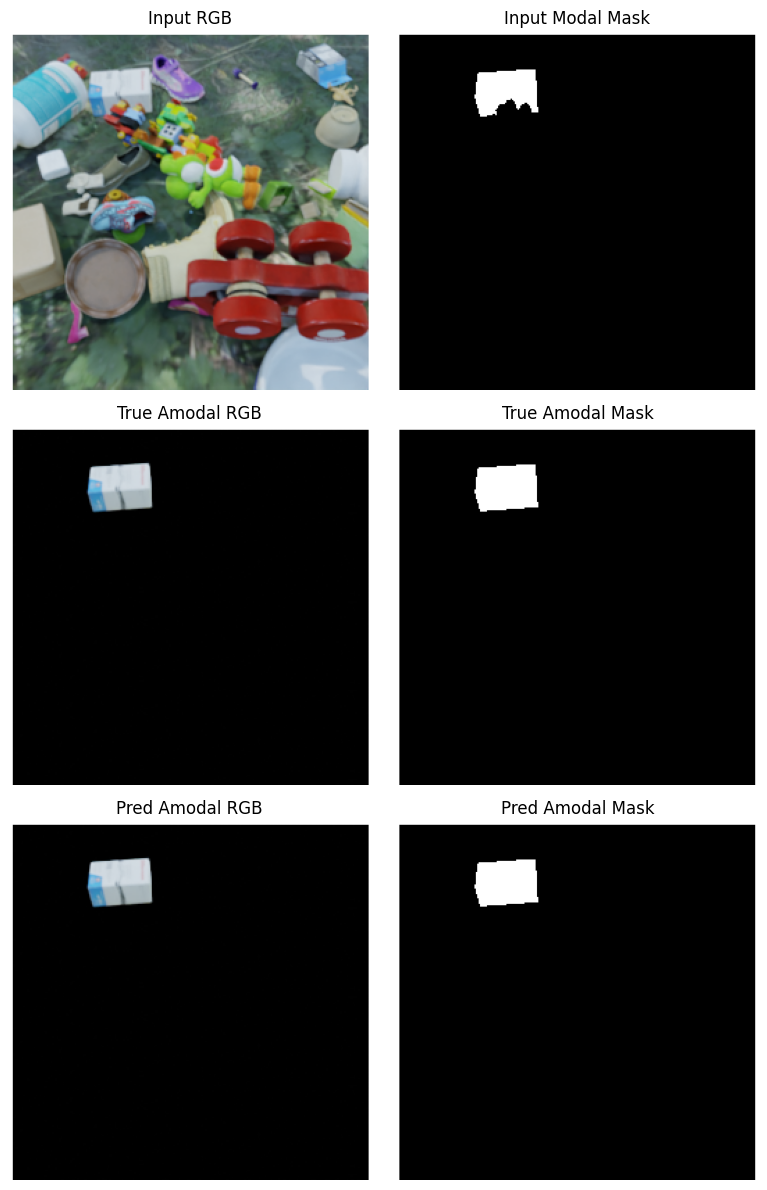

In [87]:
# Example usage:
panel_titles = [
    ['Input RGB', 'Input Modal Mask'],
    ['True Amodal RGB', 'True Amodal Mask'],
    ['Pred Amodal RGB', 'Pred Amodal Mask']
]

# Run the function
make_grid_video_with_titles(grid_tensors, panel_titles,
                            interval=200,
                             save_path="/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/offline_tests/test_video.gif")